In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import multivariate_normal

data = pd.read_csv('./data/leukemia_big.csv')
data.shape

(7128, 72)

In [2]:
import os
os.getcwd()

'/data/notebook/mfa'

In [3]:
from module.MFA import MFA

## T-test

In [4]:
data

,ALL,ALL.1,ALL.2,ALL.3,ALL.4,ALL.5,ALL.6,ALL.7,ALL.8,ALL.9,...,AML.15,AML.16,AML.17,AML.18,AML.19,AML.20,AML.21,AML.22,AML.23,AML.24
0,-1.533622,-0.867610,-0.433172,-1.671903,-1.187689,-1.127234,-1.045409,-0.106917,-1.198796,-1.190899,...,-0.436650,-1.274708,-0.681458,-0.876610,-0.624022,-0.431628,-1.435259,-0.671954,-1.013161,-0.969482
1,-1.235673,-1.275501,-1.184492,-1.596424,-1.335256,-1.113730,-0.800880,-0.745177,-0.849312,-1.190899,...,-0.915483,-1.354363,-0.653559,-1.096250,-1.066594,-1.335256,-1.204586,-0.751457,-0.889592,-1.080988
2,-0.333983,0.375927,-0.459196,-1.422571,-0.797493,-1.362768,-0.671954,-1.175674,0.320813,0.646610,...,-0.736156,-0.022153,-0.037455,-0.567335,-1.100749,-0.552938,-0.948874,-0.231657,-0.742163,-0.779500
3,0.488702,0.444011,0.436264,0.193353,0.235632,-0.360312,0.184941,0.425653,0.333983,0.235270,...,0.083781,0.356562,0.416241,0.533986,0.227505,0.416816,0.408202,0.326556,0.361813,0.298864
4,-1.300893,-1.229660,-1.325882,-1.818329,-1.311206,-1.513975,-1.651624,-1.339555,-0.593132,0.133302,...,-1.547444,-1.264475,-1.512318,-1.469583,-1.283472,-0.977672,-1.090178,-1.545120,-1.174272,-1.443183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7123,1.295992,-0.218494,1.132893,1.113077,0.719203,1.490610,0.483163,1.433292,0.737309,0.633018,...,1.097533,1.154533,1.401608,1.442685,1.097212,0.616776,0.904313,0.861478,1.183783,1.500833
7124,0.733853,0.378380,0.475669,0.148928,0.419502,1.000031,0.258833,-0.498831,-0.657700,-0.373663,...,0.496841,0.390495,0.379136,0.833781,0.298680,-0.161740,0.254654,0.558272,0.290234,0.159425
7125,-0.301622,-0.663166,-0.530138,-0.625945,-0.487514,-0.172972,-0.052590,-0.512817,-1.005845,-1.245923,...,-0.340496,-0.419886,-0.502218,-0.455682,-0.480793,-0.518640,-0.603435,-0.637751,-0.395623,-0.584142
7126,0.133657,-0.663166,1.566946,0.871972,0.358999,0.080430,0.029891,1.553879,-0.144841,0.129578,...,1.586444,0.216334,1.708574,1.710849,0.844280,1.771676,0.503216,0.079548,0.311388,0.793874


In [5]:
ALL_columns = [c for c in data.columns if 'ALL' in c]
AML_columns = [c for c in data.columns if 'AML' in c]
ttest_df = pd.DataFrame(columns=['sampleId','ttest'])
ttest ,pvalue = scipy.stats.ttest_ind(data.T.loc[ALL_columns], data.T.loc[AML_columns])
ttest_df = pd.DataFrame([ttest, pvalue], index=['ttest', 'pvalue']).T
select100 = ttest_df.sort_values('pvalue').iloc[:100].index
X = data.iloc[select100].values
np.random.seed(1234)

In [6]:
gene_type = data.iloc[select100].T.reset_index().rename(columns={'index':'gene_type'})

In [7]:
gene_type_true = np.argmax(pd.get_dummies(gene_type.gene_type.apply(lambda x: x.split('.')[0]))[['AML', 'ALL']].values, axis=1)

In [151]:
class MFA:
    def __init__(self, X, n_cluster=None, n_factor=None):
        # mean_x = np.mean(X, axis=1, keepdims=True)
        self.X = X
        self.D, self.N = X.shape
        # set hyper parameter
        '''
        n_factor : The number of latent value (q)
        n_cluster : The number of cluster
        '''
        self.n_factor = n_factor
        self.n_cluster = n_cluster
        # E_step parameter
        self.Es = None
        self.Ess = None
        self.Rjt = None
        # M_step parameter
        self.pi = None
        self.mu = None
        self.A = None
        self.sigma = None

    def _initializer(self):
        self.mu = X.copy()
        np.random.shuffle(self.mu)
        self.mu = self.mu[:,:self.n_cluster].T.reshape(self.n_cluster, self.D, 1)
        self.A = np.ones((self.n_cluster, self.D, self.n_factor))
        self.pi = np.array([1] * self.n_cluster) / self.n_cluster  # (K,) array
#         self.sigma = np.diag(np.arange(self.D) + 1 + np.exp(-700))
        self.sigma = np.diag(np.diag(X.dot(X.T)))
        self.cll = [np.inf]

    def E_step(self):
        Es = np.zeros((self.n_cluster, self.N, self.n_factor)) 
        Ess = np.zeros((self.n_cluster, self.N, self.n_factor, self.n_factor))
        Rjt = np.zeros((self.n_cluster, self.N))
        X_center = self.X - self.mu
        for j in range(self.n_cluster):
            Rjt[j] = self.pi[j] * multivariate_normal.pdf(self.X.T, self.mu[j].flatten(), self.A[j,:]@self.A[j,:].T + self.sigma + np.exp(-700))
            phi = self.A[j,:].T @ np.linalg.inv(self.A[j,:] @ self.A[j,:].T + self.sigma) # phi
        
            Es[j] = (phi @ X_center[j]).T 
            for t in range(self.N):
                Ess[j,t] = np.eye(self.n_factor) - phi @ self.A[j] + phi @ X_center[j,:, t].reshape(-1,1) @ X_center[j,:, t].reshape(-1,1).T @ phi.T
        Rjt = Rjt/Rjt.sum(axis=0, keepdims=True)
        self.Es, self.Ess, self.Rjt =  Es, Ess, Rjt

    def M_step(self):
        # new A
        A_new = np.zeros(shape=(self.n_cluster, self.D, self.n_factor))
        for j in range(self.n_cluster):
            Aj1 = np.zeros(shape=(self.D, self.n_factor))
            Aj2 = np.zeros(shape=(self.n_factor, self.n_factor))
            for t in range(self.N):
                Aj1 += self.Rjt[j,t] * ((self.X[:,t].reshape(-1,1) - self.mu[j]) @ self.Es[j,t].reshape(1,-1))
                Aj2 += self.Rjt[j,t] * self.Ess[j,t]
            A_new[j,:,:] = Aj1 @ np.linalg.inv(Aj2)
        # new mu
        mu_new = np.zeros(shape=(self.D, self.n_cluster))
        for j in range(self.n_cluster):
            temp_muj = np.zeros(shape=(self.D, 1))
            for t in range(self.N):
                temp_muj += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - A_new[j,:,:] @ self.Es[j,t].reshape(-1,1)))
            mu_new[:,j] = (temp_muj/self.Rjt[j,:].sum()).flatten()
        mu_new = mu_new.T[:,:,np.newaxis]
        # new sigma
        sigma_new = np.zeros(shape=(self.D, self.D))
        for j in range(self.n_cluster):
            for t in range(self.N):
                sigma_new += self.Rjt[j,t]*((self.X[:,t].reshape(-1,1) - mu_new[j]) @ (self.X[:,t].reshape(-1,1) - mu_new[j]).T - (A_new[j,:,:] @ self.Es[j,t].reshape(-1,1) @ (self.X[:,t].reshape(-1,1) - mu_new[j]).T))
        sigma_new = (1/self.N)*np.diag(np.diag(sigma_new))
        # new pi
        pi_new = self.Rjt.mean(axis=1)
        self.A, self.mu, self.sigma, self.pi =  A_new, mu_new, sigma_new, pi_new

    def loss_function(self):
        self.loss = 0
        inv_sigma = np.linalg.inv(self.sigma)
        for j in range(self.n_cluster):
            for t in range(self.N):
                loss_temp = np.log(self.pi[j]) - 0.5*(self.X[:,t] @ inv_sigma @ self.X[:,t] - 2 * self.X[:,t] @ inv_sigma @ self.A[j] @ self.Es[j, t] \
                                              -2 * self.X[:,t] @ inv_sigma @ self.mu[j].reshape(-1) + 2 * self.mu[j].reshape(-1) @ inv_sigma @ self.A[j]@ self.Es[j,t]\
                                              + np.matrix.trace(self.A[j].T @ inv_sigma @ self.A[j] @ self.Ess[j,t]) + self.mu[j].reshape(-1) @ inv_sigma @self.mu[j].reshape(-1))
                det_sigma = np.linalg.det(self.sigma + np.exp(-700))
                loss = self.Rjt[j,t]*(loss_temp - 0.5 * np.log(det_sigma) + (self.D/2)*np.log(2*np.pi))
                self.loss += loss
        # print(np.isnan(np.log(det_sigma)))
        print("completed log-likelihood : ", self.loss)

    def fit(self, max_iter=20, tol_el=1e-1):
        iter_ = 0
        self._initializer()
        while iter_ < max_iter:
            self.E_step()
            self.M_step()
            self.loss_function()
            if abs(self.cll[-1] - self.loss) < tol_el:
                print("old_loss : ", self.cll[-1])
                print("new_loss : ", self.loss)
                break
            self.cll.append(self.loss)
            iter_ += 1

    def plot_loglikelihood(self):
        plot_x = [-1*p for p in self.cll]
        plt.plot(plot_x)
        plt.show()

In [152]:
def cluster_accuracy(true, cluster):
    ca = np.sum(true == cluster) / cluster.shape[0]
    return ca

## m_factor = 2, n_cluster = 2

completed log-likelihood :  6146.13256034787
completed log-likelihood :  9611.384496471772
completed log-likelihood :  10614.281214445184
completed log-likelihood :  10818.63395533029
completed log-likelihood :  10995.873279736627
completed log-likelihood :  11004.751505053013
completed log-likelihood :  11004.805091735672
old_loss :  11004.751505053013
new_loss :  11004.805091735672


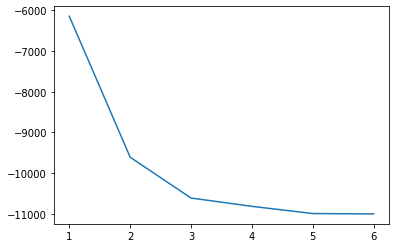

In [157]:
mfa = MFA(X, 2, 2)
mfa.fit()
mfa.plot_loglikelihood()

In [158]:
gene_type_cluster = np.argmax(mfa.Rjt.T, axis=1)

In [159]:
cluster_accuracy(gene_type_true, gene_type_cluster)

0.6944444444444444

In [160]:
X.T.shape

(72, 100)

## n_cluster = 2, n_factor = 6

In [163]:
mfa2 = MFA(X, n_cluster=2, n_factor=6)
mfa2.fit(max_iter=50)

completed log-likelihood :  2229.503525634255
completed log-likelihood :  9103.202219694098
completed log-likelihood :  10111.834081512794
completed log-likelihood :  10247.175146895326
completed log-likelihood :  10283.946956300131
completed log-likelihood :  10320.868746837788
completed log-likelihood :  10361.170932488503
completed log-likelihood :  10404.197150453336
completed log-likelihood :  10448.949468168625
completed log-likelihood :  10494.206208555524
completed log-likelihood :  10538.67193981368
completed log-likelihood :  10581.15406203381
completed log-likelihood :  10625.925478917623
completed log-likelihood :  10937.65155536637
completed log-likelihood :  11517.489257512672
completed log-likelihood :  11605.597391810492
completed log-likelihood :  12064.35862455019
completed log-likelihood :  12171.51370531973
completed log-likelihood :  12199.124709149117
completed log-likelihood :  12360.884657145196
completed log-likelihood :  12657.565459186797
completed log-likeli

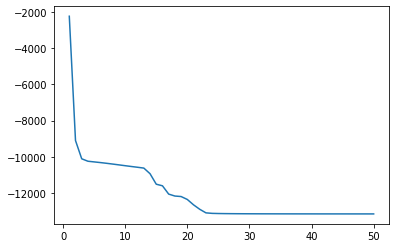

In [164]:
mfa2.plot_loglikelihood()

In [165]:
mfa2.Rjt.shape

(2, 72)

In [168]:
gene_type_cluster2 = np.argmin(mfa2.Rjt.T, axis=1)

In [169]:
cluster_accuracy(gene_type_true, gene_type_cluster2)

0.9861111111111112

## n_factor = 4, n_cluster = 6

In [172]:
mfa3 = MFA(X, 6, 4)
mfa3.fit(max_iter=60)

completed log-likelihood :  5052.733034704588
completed log-likelihood :  9286.828338609343
completed log-likelihood :  10762.863649850664
completed log-likelihood :  11123.998268907386
completed log-likelihood :  11376.090624819597
completed log-likelihood :  11448.784470852734
completed log-likelihood :  11505.214631973568
completed log-likelihood :  11560.08551660415
completed log-likelihood :  11609.931915215699
completed log-likelihood :  11653.143027735463
completed log-likelihood :  11690.090979148103
completed log-likelihood :  11722.669855225166
completed log-likelihood :  11856.408937807875
completed log-likelihood :  12463.655456714407
completed log-likelihood :  12947.291198515979
completed log-likelihood :  13690.183103829557
completed log-likelihood :  14011.62642667351
completed log-likelihood :  14176.625133838585
completed log-likelihood :  14331.060020647823
completed log-likelihood :  14415.468718679793
completed log-likelihood :  14437.824243310486
completed log-lik

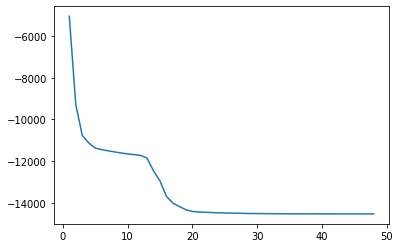

In [173]:
mfa3.plot_loglikelihood()